# Accesibilidad a áreas verdes en la Zona Metropolitana del Valle de México

En este taller vamos a calcular diferentes modelos de accesibilidad a escuelas primarias. La idea es ir trabajando de lo más simple a los más complejo. Empezaremos con un modelo de conectividad basado sólo en distancias entre centroides e iremos complicando las cosas a partir de ahí, primero usando conectividad de red...

## Preparación de datos

Como siempre, lo primero que tenemos que hacer es preparar los datos. En este caso vamos a usar el marco cartográfico del Censo de 2020 a nivel AGEB y una cartografía de áreas verdes que preparé para un proyecto integrando datos de INEGI y de OSM.

La cartografía de áreas verdes viene en un geopackage para todo el país y la cartografía censal viene en shapes para la CDMX y el Estado de México. Para cortar todo con la silueta de la ZMVM tenemos un shaper con el límite metropolitano.

Los datos para obtener la demanda (población, en principio) vienen en csvs que tenemos que unir con la geometría de las manzanas. Eso lo haremos después de tener los recortes para economizar un poco.

In [1]:
#!pip install geopandas access contextily

In [2]:
import pandas as pd
import geopandas as gpd
from access import Access, weights
import matplotlib.pyplot as plt
import contextily as ctx
import math
import numpy as np

/home/david/.local/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


### Leer datos

In [3]:
escuelas_cdmx = pd.read_excel(r"./datos/concentrado_escuelas_cdmx.xlsx")
escuelas_cdmx.head()
print(escuelas_cdmx.shape)

(3300, 40)


In [4]:
escuelas_edomex = pd.read_excel('./datos/concentrado_escuelas_edomex.xlsx')
escuelas_edomex.head()
print(escuelas_edomex.shape)

(9152, 40)


In [5]:
# Concateno los df de las escuelas de la cdmx y el edomex
#frames = [escuelas_cdmx, escuelas_edomex]
escuelas_zm = pd.concat([escuelas_cdmx, escuelas_edomex])
print(escuelas_zm.head())
print(escuelas_zm.shape)

  Clave del centro de trabajo Clave del turno Nombre del turno  \
0                  09DPR1317S               2       VESPERTINO   
1                  09PPR1197A               1         MATUTINO   
2                  09DPR0943D               1         MATUTINO   
3                  09DPR1177I               1         MATUTINO   
4                  09DPR1217T               2       VESPERTINO   

                Nombre del centro de trabajo Tipo educativo Nivel educativo  \
0                   PROFR. DANIEL DELGADILLO         BÁSICA        PRIMARIA   
1  "COLEGIO ""TRILINGÜE PEDRO MARIA ANAYA"""         BÁSICA        PRIMARIA   
2             ING. JOAQUIN GALLO MONTERRUBIO         BÁSICA        PRIMARIA   
3                            JUANA DE ASBAJE         BÁSICA        PRIMARIA   
4                         ING. ROBERTO GAYOL         BÁSICA        PRIMARIA   

  Servicio educativo Nombre del control (Público o Privado)  \
0            GENERAL                                PÚBLICO   
1 

In [6]:
escuelas_zm_gdf = gpd.GeoDataFrame(
    escuelas_zm, geometry=gpd.points_from_xy(
        escuelas_zm['Ubicación de la escuela-localidad al Oeste del Meridiano de Greenwich, expresada en grados'], 
                      escuelas_zm['Ubicación de la escuela-localidad al norte del Ecuador, expresada en grados']))

In [7]:
escuelas_zm_gdf.head()

,Clave del centro de trabajo,Clave del turno,Nombre del turno,Nombre del centro de trabajo,Tipo educativo,Nivel educativo,Servicio educativo,Nombre del control (Público o Privado),Tipo de sostenimiento,Clave de la entidad federativa,...,Docentes total (mujeres),Docentes total,Aulas en uso,Aulas existentes,"Tipo de localidad U - Urbano, R - Rural","Ubicación de la escuela-localidad al Oeste del Meridiano de Greenwich, expresada en grados, minutos y segundos","Ubicación de la escuela-localidad al norte del Ecuador, expresada en grados, minutos y segundos","Ubicación de la escuela-localidad al Oeste del Meridiano de Greenwich, expresada en grados","Ubicación de la escuela-localidad al norte del Ecuador, expresada en grados",geometry
0,09DPR1317S,2,VESPERTINO,PROFR. DANIEL DELGADILLO,BÁSICA,PRIMARIA,GENERAL,PÚBLICO,FEDERAL,9.0,...,6.0,6.0,6.0,17.0,NaN,99:6:48.60 W,19:28:58.44 N,-99.1135,19.4829,POINT (-99.11350 19.48290)
1,09PPR1197A,1,MATUTINO,"""COLEGIO """"TRILINGÜE PEDRO MARIA ANAYA""""""",BÁSICA,PRIMARIA,GENERAL,PRIVADO,PRIVADO,9.0,...,3.0,3.0,6.0,6.0,NaN,99:11:3.84 W,19:29:2.76 N,-99.1844,19.4841,POINT (-99.18440 19.48410)
2,09DPR0943D,1,MATUTINO,ING. JOAQUIN GALLO MONTERRUBIO,BÁSICA,PRIMARIA,GENERAL,PÚBLICO,FEDERAL,9.0,...,11.0,12.0,12.0,12.0,NaN,99:5:51.36 W,19:23:45.24 N,-99.0976,19.3959,POINT (-99.09760 19.39590)
3,09DPR1177I,1,MATUTINO,JUANA DE ASBAJE,BÁSICA,PRIMARIA,GENERAL,PÚBLICO,FEDERAL,9.0,...,9.0,12.0,12.0,12.0,NaN,99:5:33.36 W,19:21:32.40 N,-99.0926,19.3590,POINT (-99.09260 19.35900)
4,09DPR1217T,2,VESPERTINO,ING. ROBERTO GAYOL,BÁSICA,PRIMARIA,GENERAL,PÚBLICO,FEDERAL,9.0,...,7.0,10.0,10.0,18.0,NaN,99:5:33.36 W,19:21:32.40 N,-99.0926,19.3590,POINT (-99.09260 19.35900)


(12452, 41)


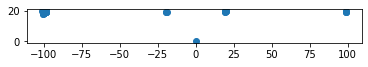

In [8]:
escuelas_zm_gdf.plot()
print(escuelas_zm_gdf.shape)

<AxesSubplot:>

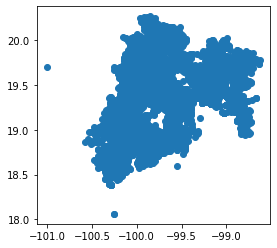

In [9]:
longitud_correcta = escuelas_zm_gdf['Ubicación de la escuela-localidad al Oeste del Meridiano de Greenwich, expresada en grados'] < -75
escuelas_zm_gdf = escuelas_zm_gdf[longitud_correcta]
escuelas_zm_gdf.plot()

In [10]:
options = ['PRIMARIA']
escuelas_zm_gdf = escuelas_zm_gdf[escuelas_zm_gdf['Nivel educativo'].isin(options)]

In [11]:
cdmx = gpd.read_file("./datos/agebs_cdmx_2020.zip")
edomex = gpd.read_file("./datos/agebs_edomex_2020.zip")
limite_metropolitano = gpd.read_file("./datos/limite_metropolitano.zip")

Hacemos un merge de las agebs para tenerlas en un solo dataframe

In [12]:
agebs_todas = pd.concat([cdmx, edomex])
agebs_todas

,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,geometry
0,0901000011716,09,010,0001,1716,"POLYGON ((2787237.541 816989.461, 2787288.728 ..."
1,0901000012150,09,010,0001,2150,"POLYGON ((2794154.458 823013.444, 2794155.774 ..."
2,0901000011133,09,010,0001,1133,"POLYGON ((2795690.723 820050.788, 2795684.238 ..."
3,0901000011307,09,010,0001,1307,"POLYGON ((2792584.475 815678.668, 2792624.325 ..."
4,0901000010281,09,010,0001,0281,"POLYGON ((2788845.392 823526.074, 2788840.549 ..."
...,...,...,...,...,...,...
4315,151250001004A,15,125,0001,004A,"POLYGON ((2808390.934 857912.251, 2808614.795 ..."
4316,1512500010016,15,125,0001,0016,"POLYGON ((2808318.468 857265.867, 2808312.961 ..."
4317,1512500010020,15,125,0001,0020,"POLYGON ((2807637.181 858200.578, 2807639.598 ..."
4318,1512500070054,15,125,0007,0054,"POLYGON ((2806574.677 856458.207, 2806484.183 ..."


<AxesSubplot:>

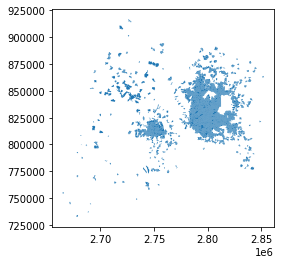

In [13]:
agebs_todas.plot()

### Proyectar
Para poder cortar las geometrías y trabajarlas todas juntas necesitamos que estén en la misma proyección

In [14]:
escuelas_zm_gdf = escuelas_zm_gdf.set_crs('epsg:4326')

Las primeras dos están en la proyección nueva de INEGI, las áreas verdes en la anterior y el límite metropolitano está en 32614. Tenemos que poner todas en la misma proyección, podría ser cualquiera de las planas (vamos a medir longitudes). Usemos la nueva del INEGI

In [15]:
escuelas_zm_gdf = escuelas_zm_gdf.to_crs(agebs_todas.crs)
limite_metropolitano = limite_metropolitano.to_crs(cdmx.crs)

In [16]:
print(escuelas_zm_gdf.crs)
print("")
print(agebs_todas.crs)

PROJCS["MEXICO_ITRF_2008_LCC",GEOGCS["GCS_ITRF_2008",DATUM["ITRF_2008",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["False_Easting",2500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-102.0],PARAMETER["Standard_Parallel_1",17.5],PARAMETER["Standard_Parallel_2",29.5],PARAMETER["Latitude_Of_Origin",12.0],UNIT["Meter",1.0]]

PROJCS["MEXICO_ITRF_2008_LCC",GEOGCS["GCS_ITRF_2008",DATUM["ITRF_2008",SPHEROID["GRS_1980",6378137.0,298.257222101]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["False_Easting",2500000.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",-102.0],PARAMETER["Standard_Parallel_1",17.5],PARAMETER["Standard_Parallel_2",29.5],PARAMETER["Latitude_Of_Origin",12.0],UNIT["Meter",1.0]]


### Cortar con el límite metropolitano

### Áreas y centroides

Como vamos a trabajar la accesibilidad en primera instancia sólo entre los centroides de las agebs y las de las áreas verdes, entonces vamos a necesitar dataframes con el área de los parques (que vamos a usar como la oferta en el modelo de accesibilidad) y con los centroides de las agebs y su población total (que va a ser la demanda).

**Nota:** vamos a hacer una copia de las capas para usdar los centroides, en caso de que queramos después usar las geometrías originales

In [17]:
#from geopandas.tools import sjoin

#escuelas_zm_gdf = sjoin(escuelas_zm_gdf, limite_metropolitano)
#agebs_zmvm = sjoin(agebs_todas, limite_metropolitano)

In [18]:
# Nos quedamos sólo con los campos que queremos
agebs_todas_centroides = agebs_todas.copy()
agebs_todas_centroides['geometry'] = agebs_todas_centroides.centroid
# Nos quedamos sólo con los campos que queremos
agebs_todas_centroides = agebs_todas_centroides.loc[:, ['CVEGEO', 'geometry']]
# Nos conviene tener una columna que identifique a cada parque
escuelas_zm_gdf = escuelas_zm_gdf[~escuelas_zm_gdf.geometry.is_empty]
escuelas_zm_gdf = escuelas_zm_gdf.reset_index().rename({'Clave del centro de trabajo':'id_escuela'}, axis=1)
escuelas_zm_gdf.head()

,index,id_escuela,Clave del turno,Nombre del turno,Nombre del centro de trabajo,Tipo educativo,Nivel educativo,Servicio educativo,Nombre del control (Público o Privado),Tipo de sostenimiento,...,Docentes total (mujeres),Docentes total,Aulas en uso,Aulas existentes,"Tipo de localidad U - Urbano, R - Rural","Ubicación de la escuela-localidad al Oeste del Meridiano de Greenwich, expresada en grados, minutos y segundos","Ubicación de la escuela-localidad al norte del Ecuador, expresada en grados, minutos y segundos","Ubicación de la escuela-localidad al Oeste del Meridiano de Greenwich, expresada en grados","Ubicación de la escuela-localidad al norte del Ecuador, expresada en grados",geometry
0,0,09DPR1317S,2,VESPERTINO,PROFR. DANIEL DELGADILLO,BÁSICA,PRIMARIA,GENERAL,PÚBLICO,FEDERAL,...,6.0,6.0,6.0,17.0,NaN,99:6:48.60 W,19:28:58.44 N,-99.1135,19.4829,POINT (2802113.976 834649.424)
1,1,09PPR1197A,1,MATUTINO,"""COLEGIO """"TRILINGÜE PEDRO MARIA ANAYA""""""",BÁSICA,PRIMARIA,GENERAL,PRIVADO,PRIVADO,...,3.0,3.0,6.0,6.0,NaN,99:11:3.84 W,19:29:2.76 N,-99.1844,19.4841,POINT (2794691.631 834634.323)
2,2,09DPR0943D,1,MATUTINO,ING. JOAQUIN GALLO MONTERRUBIO,BÁSICA,PRIMARIA,GENERAL,PÚBLICO,FEDERAL,...,11.0,12.0,12.0,12.0,NaN,99:5:51.36 W,19:23:45.24 N,-99.0976,19.3959,POINT (2803972.228 825082.509)
3,3,09DPR1177I,1,MATUTINO,JUANA DE ASBAJE,BÁSICA,PRIMARIA,GENERAL,PÚBLICO,FEDERAL,...,9.0,12.0,12.0,12.0,NaN,99:5:33.36 W,19:21:32.40 N,-99.0926,19.3590,POINT (2804578.376 821020.898)
4,4,09DPR1217T,2,VESPERTINO,ING. ROBERTO GAYOL,BÁSICA,PRIMARIA,GENERAL,PÚBLICO,FEDERAL,...,7.0,10.0,10.0,18.0,NaN,99:5:33.36 W,19:21:32.40 N,-99.0926,19.3590,POINT (2804578.376 821020.898)


### Datos de población
Para modelar la demanda necesitamos ahora unir a las agebs los datos de población, esos vienen en csvs por estado. Lo primero es leerlos y juntarlos en un solo dataframe

In [19]:
datos_cdmx = pd.read_csv("./datos/conjunto_de_datos_ageb_urbana_09_cpv2020.zip", dtype={'ENTIDAD':str, 'MUN':str, 'LOC':str, 'AGEB':str})
datos_edomex = pd.read_csv("./datos/conjunto_de_datos_ageb_urbana_15_cpv2020.zip", dtype={'ENTIDAD':str, 'MUN':str, 'LOC':str, 'AGEB':str})
datos_zmvm = pd.concat([datos_cdmx, datos_edomex])
# seleccionamos las filas que contienen los totales para cada AGEB
#datos_zmvm = datos_zmvm.loc[datos_cdmx['NOM_LOC'] == 'Total AGEB urbana', :]
# Construimos una columna con la clave de ageb
datos_zmvm['CVEGEO'] = datos_zmvm['ENTIDAD'] + datos_zmvm['MUN'] + datos_zmvm['LOC'] + datos_zmvm['AGEB']

In [20]:
datos_zmvm.loc[datos_zmvm['P_6A11'] == '*', 'P_6A11'] = 0

In [21]:
#poblacion_interes = ['P_6A11', 'P_12A14', 'P_15A17']
poblacion_interes = ['P_6A11']
datos_zmvm['SUMA'] = datos_zmvm[poblacion_interes].sum(axis=1)

In [22]:
# Nos quedamos sólo con las columnas que vamos a usar (sólo queremos los datos de población)
datos_zmvm = datos_zmvm.loc[:, ['CVEGEO', 'SUMA']]

Ahora los podemos unir con los centroides de las agebs

In [23]:
agebs_todas_centroides = agebs_todas_centroides.merge(datos_zmvm, on="CVEGEO", how="inner")
# eliminamos datos_zmvm porque ya no lo vmos a usar y ocupa mucha memoria
datos_zmvm = None
agebs_todas_centroides

,CVEGEO,geometry,SUMA
0,0901000011716,POINT (2787091.708 816590.463),667
1,0901000011716,POINT (2787091.708 816590.463),10
2,0901000011716,POINT (2787091.708 816590.463),8
3,0901000011716,POINT (2787091.708 816590.463),14
4,0901000011716,POINT (2787091.708 816590.463),16
...,...,...,...
204025,1512500070069,POINT (2806149.209 856513.490),0
204026,1512500070069,POINT (2806149.209 856513.490),0
204027,1512500070069,POINT (2806149.209 856513.490),0
204028,1512500070069,POINT (2806149.209 856513.490),0


In [24]:
# Aquí vamos a guardar todos los datos como pickle para usarlos en otros notebooks
agebs_todas_centroides.to_pickle("./datos/agebs_todas_centroides.pkl", protocol=4)
escuelas_zm_gdf.to_pickle("./datos/escuelas_centroides.pkl",protocol=4)

In [25]:
escuelas_zm_gdf

,index,id_escuela,Clave del turno,Nombre del turno,Nombre del centro de trabajo,Tipo educativo,Nivel educativo,Servicio educativo,Nombre del control (Público o Privado),Tipo de sostenimiento,...,Docentes total (mujeres),Docentes total,Aulas en uso,Aulas existentes,"Tipo de localidad U - Urbano, R - Rural","Ubicación de la escuela-localidad al Oeste del Meridiano de Greenwich, expresada en grados, minutos y segundos","Ubicación de la escuela-localidad al norte del Ecuador, expresada en grados, minutos y segundos","Ubicación de la escuela-localidad al Oeste del Meridiano de Greenwich, expresada en grados","Ubicación de la escuela-localidad al norte del Ecuador, expresada en grados",geometry
0,0,09DPR1317S,2,VESPERTINO,PROFR. DANIEL DELGADILLO,BÁSICA,PRIMARIA,GENERAL,PÚBLICO,FEDERAL,...,6.0,6.0,6.0,17.0,NaN,99:6:48.60 W,19:28:58.44 N,-99.113500,19.482900,POINT (2802113.976 834649.424)
1,1,09PPR1197A,1,MATUTINO,"""COLEGIO """"TRILINGÜE PEDRO MARIA ANAYA""""""",BÁSICA,PRIMARIA,GENERAL,PRIVADO,PRIVADO,...,3.0,3.0,6.0,6.0,NaN,99:11:3.84 W,19:29:2.76 N,-99.184400,19.484100,POINT (2794691.631 834634.323)
2,2,09DPR0943D,1,MATUTINO,ING. JOAQUIN GALLO MONTERRUBIO,BÁSICA,PRIMARIA,GENERAL,PÚBLICO,FEDERAL,...,11.0,12.0,12.0,12.0,NaN,99:5:51.36 W,19:23:45.24 N,-99.097600,19.395900,POINT (2803972.228 825082.509)
3,3,09DPR1177I,1,MATUTINO,JUANA DE ASBAJE,BÁSICA,PRIMARIA,GENERAL,PÚBLICO,FEDERAL,...,9.0,12.0,12.0,12.0,NaN,99:5:33.36 W,19:21:32.40 N,-99.092600,19.359000,POINT (2804578.376 821020.898)
4,4,09DPR1217T,2,VESPERTINO,ING. ROBERTO GAYOL,BÁSICA,PRIMARIA,GENERAL,PÚBLICO,FEDERAL,...,7.0,10.0,10.0,18.0,NaN,99:5:33.36 W,19:21:32.40 N,-99.092600,19.359000,POINT (2804578.376 821020.898)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12415,9139,15EBA1293F,3,NOCTURNO,EMILIANO ZAPATA,BÁSICA,PRIMARIA,GENERAL,PÚBLICO,ESTATAL,...,NaN,NaN,NaN,NaN,NaN,99:17:12.33 W,19:27:22.73 N,-99.286758,19.456315,POINT (2784037.759 831361.760)
12416,9140,15EBA1420L,3,NOCTURNO,NUCLEO ESCOLAR NO 7 GRAL. MELCHOR MUZQUIZ,BÁSICA,PRIMARIA,GENERAL,PÚBLICO,ESTATAL,...,NaN,NaN,NaN,NaN,NaN,99:30:42.48 W,19:17:7.44 N,-99.511800,19.285400,POINT (2760808.830 812071.496)
12417,9141,15EBA1420L,4,DISCONTINUO,NUCLEO ESCOLAR NO 7 GRAL. MELCHOR MUZQUIZ,BÁSICA,PRIMARIA,GENERAL,PÚBLICO,ESTATAL,...,NaN,NaN,NaN,NaN,NaN,99:30:42.48 W,19:17:7.44 N,-99.511800,19.285400,POINT (2760808.830 812071.496)
12418,9142,15EBA1295D,3,NOCTURNO,SOR JUANA INES DE LA CRUZ,BÁSICA,PRIMARIA,GENERAL,PÚBLICO,ESTATAL,...,NaN,NaN,NaN,NaN,NaN,99:17:21.67 W,19:26:10.77 N,-99.289354,19.436325,POINT (2783807.725 829150.673)


In [ ]:
lista = []

for index, ageb in agebs_todas_centroides.iterrows():
    for i, ageb in escuelas_zm_gdf.iterrows():
        lista.append([agebs_todas_centroides.CVEGEO[index],escuelas_zm_gdf.id_escuela[i],
                      float(math.sqrt(pow(agebs_todas_centroides.geometry[index].x-escuelas_zm_gdf.geometry[i].x,2)
                                      +pow(agebs_todas_centroides.geometry[index].y-escuelas_zm_gdf.geometry[i].y,2)))])
        
df = pd.DataFrame(lista,columns=['origin','dest','euclidean'])
df.head()

In [ ]:
df.to_csv("./datos/escuelas_od_euclidean.csv", index=False)

## Modelo basado en distancia euclidiana

La primera aproximación que vamos a usar es crear un modelo de accesibilidad basado en la distancia euclidiana entre los centroides de las agebs y los de los parques. Para esto, el primer paso es construir una matriz de costos

### Matriz de costos

Para construir la matriz de costos necesitamos obtener el producto cruz de nuestros datos de origen y destino. A partir de eso, podemos calcular la distancia euclidiana y guardar el resultado en la matriz. En general, podríamos ralizar todo el proceso con el siguiente código:

````Python
# Creamos el producto cruz
#cost_df = agebs_zmvm_centroides[['CVEGEO']].merge(areas_verdes_centroides[['id_parque']], how='cross')
cost_df = agebs_zmvm_centroides[['CVEGEO']].merge(escuelas[['id_escuela']], how='cross')
# Agregamos una columna de costo con puros ceros
cost_df['cost'] = 0
# renombramos las columnas para que tengan más sentido
cost_df.columns = ['origen', 'destino', 'cost']
# Instanciamos un objeto de la clase Access
A = Access(demand_df            = agebs_zmvm_centroides,
           demand_index         = 'CVEGEO',
           demand_value         = 'sum',
           supply_df            = areas_verdes_centroides,
           supply_index         = 'id_escuela',
           supply_value         = 'area',
           cost_df              = costo_euclidiano,
           cost_origin          = 'origin',
           cost_dest            = 'dest',
           cost_name            = 'euclidean',
           neighbor_cost_df     = costo_euclidiano,
           neighbor_cost_origin = 'origin',
           neighbor_cost_dest   = 'dest',
           neighbor_cost_name   = 'euclidean')
# Calculamos las distancias
A.create_euclidean_distance(threshold = 250000, centroid_o = True, centroid_d = True)
````
Como esta operación requiere mucha memoria y tiempo, en lugar de ejecutarla vamos a usar un dataframe con los datos precalculados

In [ ]:
costo_euclidiano = pd.read_csv("./datos/primarias_od_euclidean.csv")
costo_euclidiano

### Instancia de accesibilidad

Ya tenemos los datos preparados, ahora podemos crear una instancia de la clase `access` con nuestros centros de demanda y de oferta. 

In [ ]:
from access import Access, weights
A = Access(demand_df            = cdmx_centroides,
           demand_index         = 'CVEGEO',
           demand_value         = 'sum',
           supply_df            = escuelas,
           supply_index         = 'id_escuela',
           supply_value         = 'matricula',
           cost_df              = costo_euclidiano,
           cost_origin          = 'origin',
           cost_dest            = 'dest',
           cost_name            = 'euclidean',
           neighbor_cost_df     = costo_euclidiano,
           neighbor_cost_origin = 'origin',
           neighbor_cost_dest   = 'dest',
           neighbor_cost_name   = 'euclidean')

### Modelos de accesibilidad
Ahora ya tenemos todos los datos que necesitamos para calcular diferentes modelos de accesibilidad. El ajuste de cada modelos para la cantidad de datos que estamos utilizando es un poco lento, entonces vamos a calcular sólo unos pocos y ver sus diferencias

In [ ]:
# stepwise weight dictionaries
fn1 = weights.step_fn({750 : 1, 1500 : 0.68, 3000 : 0.22})
# gaussian media de 1000 metros 
gaussian = weights.gaussian(750)
# gravity catchement pesado por gravedad
gravity = weights.gravity(scale = 750, alpha = -1)

In [ ]:
A.weighted_catchment(name = "gravity", weight_fn = gravity)
A.raam(name = "raam", tau = 5)

In [ ]:
# Guardamos los modelos por si los queremos reutilizar
A.norm_access_df.to_csv("./datos/accesibilidad_primarias_distancia_euclidiana.csv")

Ahora podemos comparar los dos modelos de accesibilidad. Primero unimos los datos de acceesibilidad a las geometrías de los centroides 

In [ ]:
mapa_accesibilidad = cdmx_centroides.set_index('CVEGEO')[['geometry']].join(A.norm_access_df, how = "inner")
mapa_accesibilidad

Y ahora podemos hacer un par de mapas para compararlos

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(32,12))
ax1 = mapa_accesibilidad.to_crs(epsg=3857).plot('raam_matricula', legend = True,
                                                cmap =  "viridis_r", 
                                                markersize = 5, alpha = 0.9, ax = ax1,
                                                vmin = mapa_accesibilidad['raam_matricula'].quantile(0.05), 
                                                vmax = mapa_accesibilidad['raam_matricula'].quantile(0.95),
                                                )
ax1.set_axis_off()
ax1.set(title='Modelo RAAM')
ctx.add_basemap(ax1, source=ctx.providers.CartoDB.Positron)

ax2 = mapa_accesibilidad.to_crs(epsg=3857).plot('gravity_matricula', legend = True,
                                                cmap =  "viridis", 
                                                markersize = 5, alpha = 0.9, ax = ax2,
                                                vmin = mapa_accesibilidad['gravity_matricula'].quantile(0.05), 
                                                vmax = mapa_accesibilidad['gravity_matricula'].quantile(0.95),
                                                )
ax2.set_axis_off()
ax2.set(title='Modelo Gravitatorio')
# plt.subplots_adjust(wspace=-.5, hspace=0)
ctx.add_basemap(ax2, source=ctx.providers.CartoDB.Positron)
plt.tight_layout()

Hasta aquí hicimos nuestro primer modelo de accesibilidad utilizando nuestros propios datos. Por supuesto tiene algunas limitaciones obvias: la distancia está modelada _as the crow flies_, lo que no necesariamente corresponde con la realidad; la oferta asume que la capacidad de cada área verde depende únicamente del área, etcétera.

Pensemos ahora, además de esas limitaciones obvias, en qué modelos de conectividad funciona mejor para el problema que estamos abordando ¿gravitatorio? ¿RAAM? Lean los artículos, piénsenlo y argumentemos para la próxima clase. 